<a href="https://colab.research.google.com/github/flotep/bioresponse/blob/branch_FT/bioresponse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
#Download Kaggle Data in Google Colab.
!pip install -q kaggle

In [14]:
from google.colab import files
files.upload()#Choisir le kaggle.json téléchargé : Kaggle > Account > API > Create New API Token

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"floriantep","key":"3da64d38bed69d675380518a0dc12562"}'}

In [15]:
#Création d'un dossier kaggle, copie de kaggle.json dedans.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
#Change les permissions du fichier json.
!chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets list
#Téléchargements des données du projet.
!kaggle competitions download -c bioresponse
#Création des dossiers train et test où on extrait les fichiers zip. 
!mkdir train 
!mkdir test
!unzip -q train.csv.zip -d train
!unzip -q test.csv.zip -d test
!ls

kaggle.json
svm_benchmark.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘train’: File exists
mkdir: cannot create directory ‘test’: File exists
replace train/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
'kaggle (1).json'   sample_data         test	       train
 kaggle.json	    svm_benchmark.csv   test.csv.zip   train.csv.zip


In [88]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from sklearn.ensemble import ExtraTreesClassifier


# Chargement des données

In [18]:
def read_data(file_path):
    with open(file_path) as f:
        f.readline()    # skip header
        samples = []
        for line in f:
            line = line.split(",") #split the string into a list (the separator is the comma)
            sample = [float(x) for x in line]
            samples.append(sample)
    return samples #list of list, each list contains all the descriptor of one molecule (structure and composition).

def load(train_path, test_path, benchmark_path): #renvoie des arrays
    train = read_data(train_path)
    benchmark = read_data(benchmark_path)
    y_train = np.array([x[0] for x in train])#output train : the first colum of each molecules rows "Activty" -> 1 = elicit the biological response, 0 = no biological response
    X_train = np.array([x[1:] for x in train])#input train : every column of the molecules rows, except the 1st column
    
    X_test = np.array(read_data(test_path))#input test : already without the first column containing the biological response
    y_test = np.array([x[1] for x in benchmark])#output expected for the test
    return X_train, y_train, X_test, y_test

def load_pd(train_path, test_path, benchmark_path): #renvoie des dataframe
    train = pd.read_csv(train_path)
    benchmark = pd.read_csv(benchmark_path)
   
    X_train = train.iloc[:,1:1777] 
    Y_train = train.iloc[:,0]

    X_test = pd.read_csv(test_path)
    Y_test = benchmark.iloc[:,1]
    return X_train, Y_train, X_test, Y_test

    

In [28]:
train_path = 'train/train.csv' #3751 rows, 1777 columns
test_path = 'test/test.csv' #2501 rows, 1776 columns
benchmark_path = 'svm_benchmark.csv'#2501 rows, one value per row (between 0 and 1)

X_train, y_train, X_test, y_test = load(train_path, test_path, benchmark_path)
df_X_train, df_y_train, df_X_test, df_y_test = load_pd(train_path, test_path, benchmark_path)
train = pd.read_csv(train_path)
test_activity = pd.read_csv(benchmark_path)
#X_train = tf.stack(X_train)
#X_test = tf.stack(X_test)
print(X_train.shape) #input train = 3751 molécules, 1776 colonnes (chaque colonne = 1 descripteur)
print(X_train[0])
print(y_train.shape) #expected output train = 3751 ligne (1 pour chaque molécule), 1 colonne : prédiction -> probabilité entre 0 et 1
print(y_train[0])
print(X_test.shape)
print(X_test[0]) #test= 2501 molécules, 1776 colonnes (chaque colonne = 1 descripteur)
print(y_test.shape)
print(y_test[0])


print(df_X_train.shape) #input train = 3751 molécules, 1776 colonnes (chaque colonne = 1 descripteur)
print(df_X_train)
print(df_y_test)

(3751, 1776)
[0.         0.49700901 0.1        ... 0.         0.         0.        ]
(3751,)
1.0
(2501, 1776)
[0.36666667 0.61176451 0.05       ... 0.         1.         0.        ]
(2501,)
0.858294
(3751, 1776)
            D1        D2    D3   D4  ...  D1773  D1774  D1775  D1776
0     0.000000  0.497009  0.10  0.0  ...      0      0      0      0
1     0.366667  0.606291  0.05  0.0  ...      0      0      1      0
2     0.033300  0.480124  0.00  0.0  ...      0      0      0      0
3     0.000000  0.538825  0.00  0.5  ...      0      0      0      0
4     0.100000  0.517794  0.00  0.0  ...      0      0      0      0
...        ...       ...   ...  ...  ...    ...    ...    ...    ...
3746  0.033300  0.506409  0.10  0.0  ...      0      0      0      0
3747  0.133333  0.651023  0.15  0.0  ...      1      0      0      0
3748  0.200000  0.520564  0.00  0.0  ...      0      0      0      0
3749  0.100000  0.765646  0.00  0.0  ...      0      0      0      0
3750  0.133333  0.533952  0.0

# Exploratory Data Analysis

In [21]:
# check missing values and column names
print("Missing Values",df_X_train.isnull().sum().sum())
print("Column names",data.columns)
# select the float columns (numerical)
df_float = df_X_train.select_dtypes(include=[np.float])
print("Float Columns",df_float.columns)
print(df_float.shape)

# select int columns (categorical)
df_int = df_X_train.select_dtypes(include=[np.int])
print("Int columns",df_int.columns)
print(df_int.shape)

Missing Values 0
Column names Index(['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10',
       ...
       'D1767', 'D1768', 'D1769', 'D1770', 'D1771', 'D1772', 'D1773', 'D1774',
       'D1775', 'D1776'],
      dtype='object', length=1776)
Float Columns Index(['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10',
       ...
       'D942', 'D943', 'D944', 'D945', 'D946', 'D947', 'D948', 'D949', 'D950',
       'D951'],
      dtype='object', length=942)
(3751, 942)
Int columns Index(['D23', 'D27', 'D28', 'D51', 'D72', 'D94', 'D170', 'D568', 'D858',
       'D952',
       ...
       'D1767', 'D1768', 'D1769', 'D1770', 'D1771', 'D1772', 'D1773', 'D1774',
       'D1775', 'D1776'],
      dtype='object', length=834)
(3751, 834)


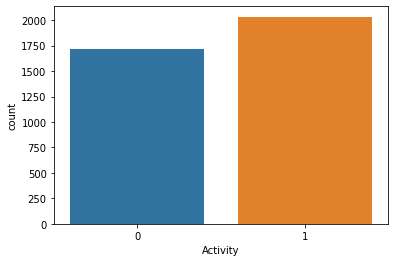

In [43]:
train_act_graph = sns.countplot(x=train["Activity"])
#train_act_graph.set_xticklabels(train_act_graph.get_xticklabels())
plt.show()

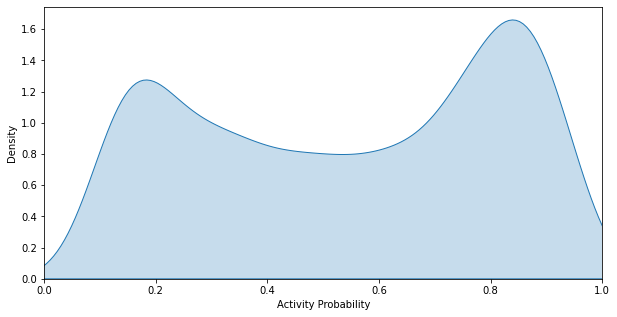

In [42]:
plt.figure(figsize=(10,5)) 
plt.xlim(0,1) 
plt.xlabel('Activity Probability')
plt.ylabel('Density') 
test_act_graph = sns.kdeplot(x=test_activity["PredictedProbability"], shade = True)
plt.show()

# Feature Selection

### A) Kbest

In [112]:
#https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
#Univariate feature selection works by selecting the best features based on univariate statistical tests.

#Regarde l'importance des descripteurs
kbest_features = SelectKBest(score_func=f_regression)
kbest_fit = kbest_features.fit(df_X_train,df_y_train)

dfscores = pd.DataFrame(kbest_fit.scores_)
dfcolumns = pd.DataFrame(df_X_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Descriptor','Score']  #naming the dataframe columns
print(featureScores)

     Descriptor       Score
0            D1   28.197757
1            D2   45.267204
2            D3  107.832861
3            D4    7.313876
4            D5   84.476080
...         ...         ...
1771      D1772    0.523618
1772      D1773    3.253320
1773      D1774    0.120508
1774      D1775    8.865198
1775      D1776    1.731779

[1776 rows x 2 columns]


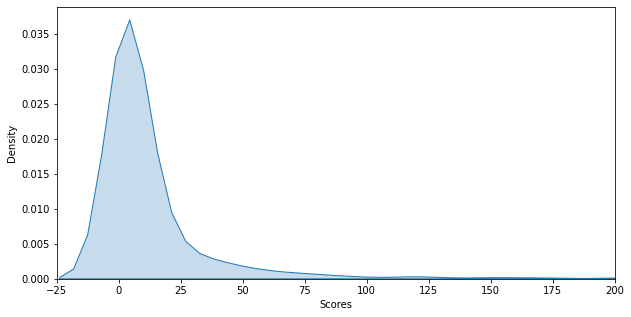

count    1.776000e+03
mean     1.294489e+01
std      3.543973e+01
min      6.151282e-07
25%      9.718127e-01
50%      4.319238e+00
75%      1.118902e+01
max      1.076620e+03
Name: Score, dtype: float64

In [91]:
plt.figure(figsize=(10,5)) 
plt.xlim(-25,200) 
plt.xlabel('Scores')
plt.ylabel('Density') 
sns.kdeplot(x=featureScores["Score"], shade = True)
plt.show()
featureScores["Score"].describe()

In [96]:
kbest_features = featureScores.loc[featureScores['Score'] > 11.2] #> 25 = 228 descripteurs restants
print(kbest_features) 
#bestFeatures = featureScores.nlargest(250,'Score')  
#print(bestFeatures)
#bestDescriptor = []
kbest_bestDescriptor = kbest_features['Descriptor'].tolist()

#print (bestDescriptor)

X_train_kbest = df_X_train.filter(items=kbest_bestDescriptor)
print(X_train_kbest)

#X_test_filter = df_X_test.filter(items=bestDescriptor)

     Descriptor       Score
0            D1   28.197757
1            D2   45.267204
2            D3  107.832861
4            D5   84.476080
5            D6   42.775793
...         ...         ...
1728      D1729   18.521387
1738      D1739   14.126535
1745      D1746   12.915126
1762      D1763   14.291980
1767      D1768   22.048653

[443 rows x 2 columns]
            D1        D2    D3        D5  ...  D1739  D1746  D1763  D1768
0     0.000000  0.497009  0.10  0.132956  ...      0      0      0      0
1     0.366667  0.606291  0.05  0.111209  ...      1      1      1      1
2     0.033300  0.480124  0.00  0.209791  ...      0      0      0      0
3     0.000000  0.538825  0.00  0.196344  ...      0      0      0      0
4     0.100000  0.517794  0.00  0.494734  ...      0      0      0      0
...        ...       ...   ...       ...  ...    ...    ...    ...    ...
3746  0.033300  0.506409  0.10  0.209887  ...      0      0      0      0
3747  0.133333  0.651023  0.15  0.151154  ...   

In [86]:
kbest = SelectKBest(score_func=f_regression, k=443)
kbest_fit = kbest.fit_transform(X_train,y_train)
print(kbest_fit.shape)

(3751, 443)


### B) Extra trees

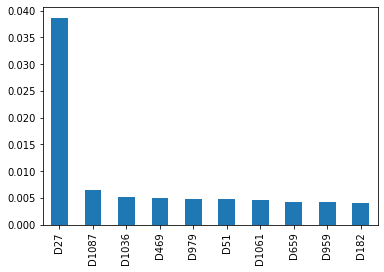

D27      0.038722
D1087    0.006395
D1036    0.005123
D469     0.005014
D979     0.004857
           ...   
D987     0.001254
D58      0.001252
D661     0.001243
D762     0.001242
D1078    0.001240
Length: 250, dtype: float64


In [114]:
#Tree-based feature selection
extra_trees = ExtraTreesClassifier()
extra_trees.fit(df_X_train,df_y_train)
#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

#plot graph of feature importances for better visualization
#feat_importances = pd.Series(extra_trees.feature_importances_, index=df_X_train.columns)

feat_importances.nlargest(10).plot(kind='bar')
extra_trees_features = feat_importances.nlargest(250)
#extra_trees_features.columns = ['Descriptor', 'Score']
plt.show()
print(extra_trees_features)


In [106]:
extra_trees_bestDescriptor = extra_trees_features.index.tolist()

X_train_extra_trees = df_X_train.filter(items=extra_trees_bestDescriptor)
print(X_train_extra_trees)

      D27  D1087  D1036  D469  D979  ...  D987       D58      D661      D762  D1078
0       1      0      1   0.0     1  ...     0  0.133438  0.181818  0.000000      1
1       0      0      0   0.0     0  ...     0  0.191837  0.227273  0.083300      1
2       0      0      0   0.0     0  ...     0  0.000000  0.000000  0.000000      0
3       0      0      0   0.0     1  ...     0  0.000000  0.000000  0.000000      0
4       0      0      0   0.0     0  ...     1  0.000000  0.000000  0.000000      0
...   ...    ...    ...   ...   ...  ...   ...       ...       ...       ...    ...
3746    1      0      1   0.0     1  ...     0  0.000000  0.000000  0.000000      1
3747    0      0      0   0.0     1  ...     0  0.011300  0.045500  0.000000      0
3748    0      1      0   0.0     1  ...     0  0.044400  0.000000  0.166667      1
3749    1      0      1   0.0     0  ...     0  0.023600  0.000000  0.000000      1
3750    0      0      0   0.0     0  ...     1  0.000000  0.000000  0.000000

# Dimensionality Reduction

In [107]:
scaler = MinMaxScaler().fit_transform(df_X_train)
scale_X_train = pd.DataFrame(scaler,columns=df_X_train.columns)
print(df_X_train)
print(scale_X_train)

            D1        D2    D3   D4  ...  D1773  D1774  D1775  D1776
0     0.000000  0.497009  0.10  0.0  ...      0      0      0      0
1     0.366667  0.606291  0.05  0.0  ...      0      0      1      0
2     0.033300  0.480124  0.00  0.0  ...      0      0      0      0
3     0.000000  0.538825  0.00  0.5  ...      0      0      0      0
4     0.100000  0.517794  0.00  0.0  ...      0      0      0      0
...        ...       ...   ...  ...  ...    ...    ...    ...    ...
3746  0.033300  0.506409  0.10  0.0  ...      0      0      0      0
3747  0.133333  0.651023  0.15  0.0  ...      1      0      0      0
3748  0.200000  0.520564  0.00  0.0  ...      0      0      0      0
3749  0.100000  0.765646  0.00  0.0  ...      0      0      0      0
3750  0.133333  0.533952  0.00  0.0  ...      0      0      0      0

[3751 rows x 1776 columns]
            D1        D2        D3   D4  ...  D1773  D1774  D1775  D1776
0     0.000000  0.314959  0.105263  0.0  ...    0.0    0.0    0.0    0.

### A) Principal Component Analysis

Text(0, 0.5, 'cumulative explained variance')

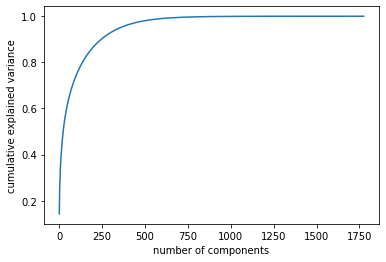

In [115]:
#Dimensionality Reduction
#This is a high dimensional data set with too many dimensions. 
#Let's use PCA and t-sne to see if we can extract features
n_components = 250

#Let's look at the cumulative variance with repsect to the number of the components
pca = PCA().fit(scale_X_train)
X_pca = PCA(n_components).fit_transform(data)
df_pca = pd.DataFrame(X_pca)
#print (df_pca)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')


#We need 500 components to describe 95 - 100 % of the variance


In [ ]:
print(pca.explained_variance_ratio_)

[1.42516784e-01 6.53600436e-02 3.50866556e-02 ... 7.24103247e-34
 7.24103247e-34 7.24103247e-34]


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Input of the model
input_shape = (1776,) #1776 descriptors
inputs = keras.Input(shape=input_shape)
print(inputs.shape)
print(inputs.dtype)
#drop_out_1 = layers.Dropout(0.2)(inputs)
#Model layers
hidden1 = layers.Dense(64, activation="relu")(inputs)
hidden2 = layers.Dense(64, activation="relu")(hidden1)

#hidden3 = layers.Dense(64, activation="relu")(hidden2), 3755 1 hidden
outputs = layers.Dense(1, activation ="linear")(hidden2) #shape = 1 -> One value between 0 and 1 (regression)
model = keras.Model(inputs=inputs, outputs=outputs,name="bioresponse_model")


(None, 1776)
<dtype: 'float32'>


In [ ]:
#Compile model
#Binary Cross-Entropy specifies that the model should optimize the log loss
model.compile(
    #loss=keras.losses.MeanSquaredError(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #Evaluate the model with the log loss 
    optimizer=keras.optimizers.SGD(learning_rate=0.01), #ou Adagrad avec haut LR
    #metrics=[soft_acc] #Compute accuracy for a regression model
    metrics=["accuracy"]
)

In [ ]:
histori=model.fit(df_X_train,df_y_train, batch_size=75, epochs= 40, validation_split=0.2)

Epoch 1/40
40/40 [==============================] - 3s 13ms/step - loss: 0.6976 - accuracy: 0.4567 - val_loss: 0.6911 - val_accuracy: 0.4621
Epoch 2/40
40/40 [==============================] - 0s 4ms/step - loss: 0.6797 - accuracy: 0.4690 - val_loss: 0.6845 - val_accuracy: 0.4714
Epoch 3/40
40/40 [==============================] - 0s 4ms/step - loss: 0.6703 - accuracy: 0.5000 - val_loss: 0.6775 - val_accuracy: 0.4780
Epoch 4/40
40/40 [==============================] - 0s 5ms/step - loss: 0.6612 - accuracy: 0.5220 - val_loss: 0.6704 - val_accuracy: 0.4993
Epoch 5/40
40/40 [==============================] - 0s 4ms/step - loss: 0.6511 - accuracy: 0.5507 - val_loss: 0.6627 - val_accuracy: 0.5140
Epoch 6/40
40/40 [==============================] - 0s 5ms/step - loss: 0.6413 - accuracy: 0.5630 - val_loss: 0.6547 - val_accuracy: 0.5419
Epoch 7/40
40/40 [==============================] - 0s 4ms/step - loss: 0.6304 - accuracy: 0.5920 - val_loss: 0.6459 - val_accuracy: 0.5779
Epoch 8/40
40/40 [=

In [ ]:
model.summary()

Model: "bioresponse_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1776)]            0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                113728    
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 117,953
Trainable params: 117,953
Non-trainable params: 0
_________________________________________________________________


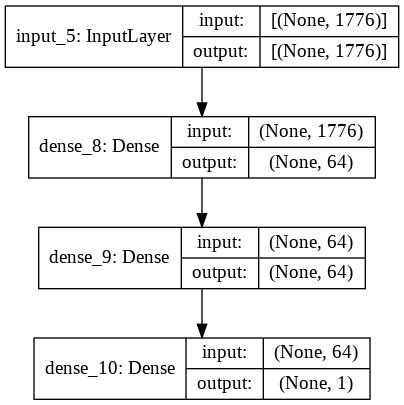

In [ ]:
keras.utils.plot_model(model, "my_first_model_show_shape.png", show_shapes=True)

In [ ]:
#https://stackoverflow.com/questions/42665359/how-do-you-compute-accuracy-in-a-regression-model-after-rounding-predictions-to
from keras import backend as K

def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))



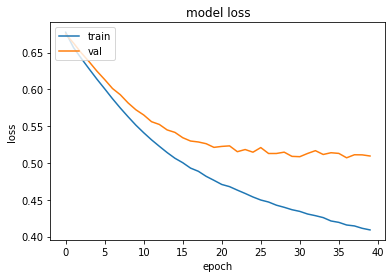

In [ ]:
import matplotlib.pyplot as plt
#Summarize history for loss
plt.plot(histori.history['loss'])
plt.plot(histori.history['val_loss'])
plt.title ('model loss')
plt.ylabel ('loss')
plt.xlabel ('epoch')
plt.legend (['train', 'val'], loc = 'upper left')
plt.show()

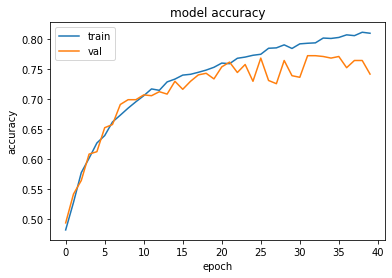

In [ ]:
plt.plot(histori.history['accuracy'])
plt.plot(histori.history['val_accuracy'])
plt.title ('model accuracy')
plt.ylabel ('accuracy')
plt.xlabel ('epoch')
plt.legend (['train', 'val'], loc = 'upper left')
plt.show()

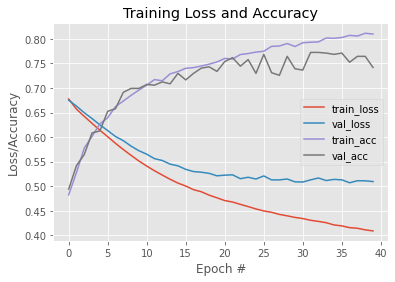

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 40), histori.history["loss"], label="train_loss")
plt.plot(np.arange(0, 40), histori.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 40), histori.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 40), histori.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [ ]:
#Test the model
loss, acc = model.evaluate(df_X_test, df_y_test, verbose=1)
print(loss)

79/79 [==============================] - 0s 3ms/step - loss: 0.5676 - accuracy: 0.0000e+00
0.5676160454750061


In [ ]:
#SHAP
!pip install shap

In [ ]:
#https://www.yourdatateacher.com/2021/05/17/how-to-explain-neural-networks-using-shap/
import shap
sample = shap.sample(df_X_train,5)
explainer = shap.KernelExplainer(model.predict,sample)
shap_values = explainer.shap_values(df_X_test,nsamples=50)


  0%|          | 0/2501 [00:00<?, ?it/s]

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=2.336e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=2.336e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=2.335e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=2.335e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce

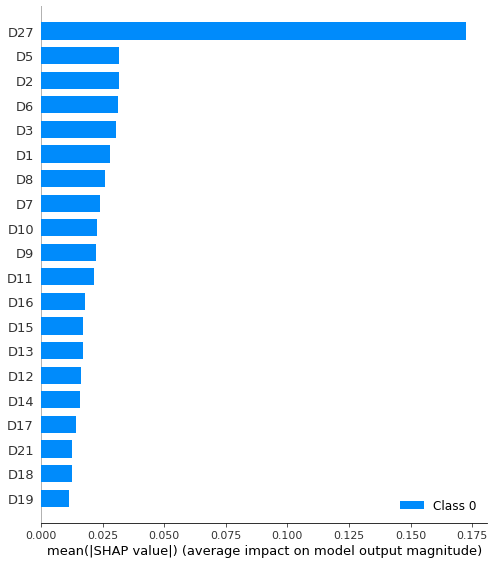

In [ ]:
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values,df_X_test,feature_names=df_X_test.columns)


In [ ]:
shap.summary_plot(shap_values[1], df_X_test)

NameError: ignored

In [ ]:
#dropout améliore pas
#KNN, EDA, SVM , SHAP, MDS, 

In [ ]:
#Auto-encoder :http://eric.univ-lyon2.fr/~ricco/tanagra/fichiers/fr_Tanagra_Keras_Autoencoder.pdf
#Standardisations des variables
std = MinMaxScaler()
#Z = std.fit_transform(df_X_train) #version df
#Z = pd.DataFrame(Z)
#print(Z)
#print(Z.shape)
Z2 = std.fit_transform(X_train) #version array

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

#Auto-Encodeur modèle
input_shape = (1776,) #1776 descriptors
inputs = keras.Input(shape=input_shape)

#Model layers
hiddenL = layers.Dense(2,activation='sigmoid')(inputs) #activity_regularizer=regularizers.l1(10e-6)
outputL = layers.Dense(1776,activation='linear')(hiddenL)

model_ae = keras.Model(inputs=inputs, outputs=outputL,name="auto_encoder_model")

model_ae.compile(
    #loss=keras.losses.BinaryCrossentropy(),
    loss=keras.losses.MeanSquaredError(),
    #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #Evaluate the model with the log loss 
    optimizer=keras.optimizers.Adam(), #ou Adagrad avec haut LR
    #metrics=[soft_acc] #Compute accuracy for a regression model
    metrics=["accuracy"]
)

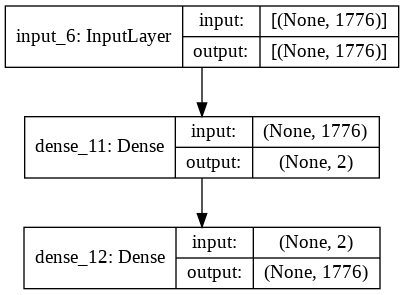

In [ ]:
keras.utils.plot_model(model_ae, "my_first_model_show_shape.png", show_shapes=True)

In [ ]:
#Entrainement
histori_ae=model_ae.fit(Z2,df_y_train, batch_size=75, epochs= 40, validation_split=0.2)

NameError: ignored

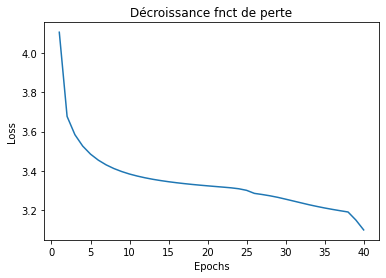

In [ ]:
#affichage de l'évolution de l'apprentissage
plt.plot(np.arange(1,41),histori_ae.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Décroissance fnct de perte')
plt.show()

In [ ]:
#Evaluation
loss, acc = model_ae.evaluate(df_X_test, df_y_test, verbose=1)
print(loss)

79/79 [==============================] - 0s 4ms/step - loss: 3.1424 - accuracy: 0.0000e+00
3.14243745803833


In [ ]:
#Utiliastion de l'ae pour prédire dans l'espace initial
ZP = model_ae.predict(Z2)
print(ZP)
print(ZP.shape)

[[ 0.35068324  0.575726   -0.04486781 ... -0.07723323 -0.04746826
   0.64482945]
 [ 0.42393956  0.70321226 -0.05856539 ... -0.10118291 -0.06225929
   0.8046567 ]
 [ 0.17828262  0.27368933 -0.01309678 ... -0.02034171 -0.01207918
   0.2656636 ]
 ...
 [ 0.21681724  0.35313678 -0.01744103 ... -0.03619433 -0.02343087
   0.36839312]
 [ 0.42201993  0.69855094 -0.05851149 ... -0.10020833 -0.06149093
   0.79847944]
 [ 0.12011182  0.17672376 -0.00123417 ... -0.00244526 -0.00156449
   0.14517725]]
(3751, 1776)


[[0.7153793  0.7299745 ]
 [0.93195885 0.96167296]
 [0.21959035 0.16061217]
 ...
 [0.24789064 0.43078688]
 [0.935413   0.93979025]
 [0.01810857 0.0277215 ]]
(3751, 2)


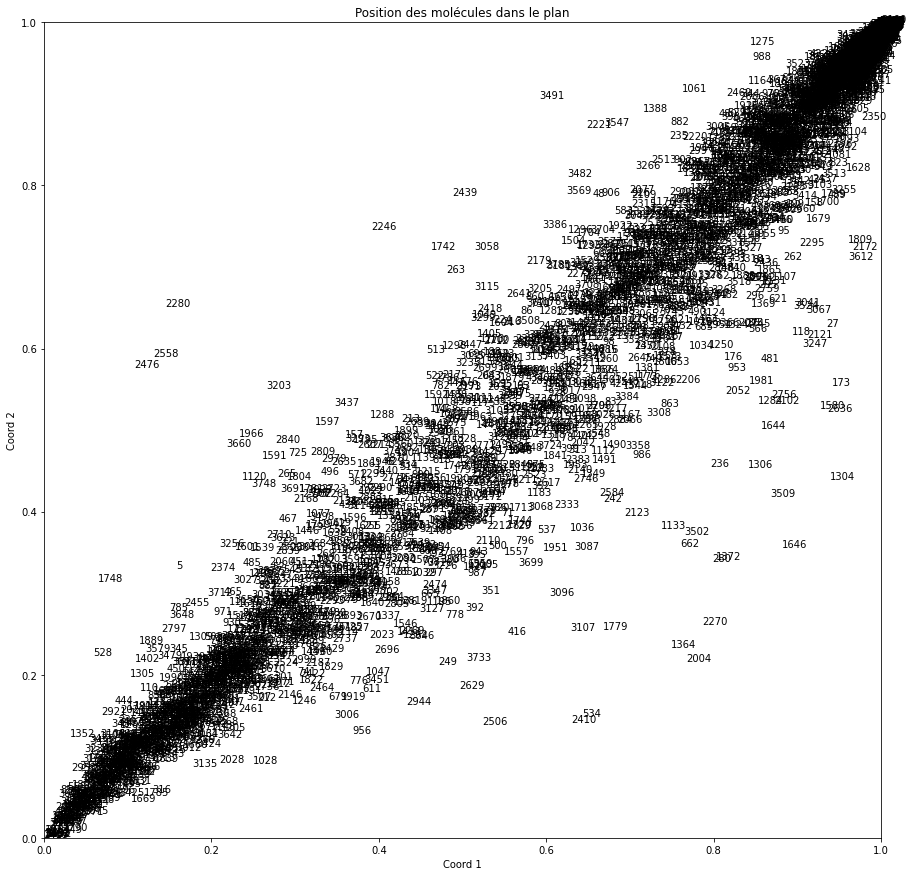

In [ ]:
#Representation dans l'espace réduit en 2 dimensions
encoder = keras.Model(inputs,hiddenL) #couche hiddenL représente les 2 neurones au milieu de l'auto-encodeur
coord = encoder.predict(Z2)
print(coord)
print(coord.shape)

#positionnement des individus dans le plan
fig, axes = plt.subplots(figsize=(15,15))
axes.set_xlim(0,1)
axes.set_ylim(0,1)
#étiquettes des points
for i in range(coord.shape[0]):
 plt.annotate(df_X_train.index[i],(coord[i,0],coord[i,1]))
#titre et axes
plt.title('Position des molécules dans le plan')
plt.xlabel('Coord 1')
plt.ylabel('Coord 2')
plt.show()



In [ ]:
#Decoder 
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(2,))
# Retrieve the last layer of the autoencoder model
decoder_layer = model_ae.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

encoded_data = encoder.predict(df_X_test)
print(encoded_data)
print(encoded_data.shape)
decoded_data = decoder.predict(encoded_data)
print(decoded_data)
print(decoded_data.shape)


[[0.9305276  0.9598967 ]
 [0.9733945  0.97315377]
 [0.53550345 0.5387281 ]
 ...
 [0.9677953  0.96064526]
 [0.9179124  0.89838326]
 [0.13084732 0.11377496]]
(2501, 2)
[[ 0.42342585  0.7023056  -0.05847226 ... -0.10101164 -0.06215192
   0.80351686]
 [ 0.43398926  0.7190055  -0.06083623 ... -0.10402285 -0.06379943
   0.82402825]
 [ 0.28998488  0.47015524 -0.0335042  ... -0.0574052  -0.03523044
   0.51249284]
 ...
 [ 0.43130842  0.71400356 -0.0604127  ... -0.10305797 -0.0631611
   0.81767243]
 [ 0.41336185  0.6823122  -0.05716313 ... -0.09707    -0.0594051
   0.7778255 ]
 [ 0.15407304  0.23404154 -0.00799639 ... -0.01307942 -0.00790713
   0.216585  ]]
(2501, 1776)


In [ ]:
correlations = np.zeros(shape=(1776,2))
for j in range(coord.shape[1]):
  for i in range(Z2.shape[1]):
    correlations[i,j]=np.corrcoef(coord[:,j],Z2[:,i])[0,1]

dfCorr = pd.DataFrame(correlations,columns=['Corr_1','Corr_2'],index=df_X_train.columns)
print(dfCorr)



         Corr_1    Corr_2
D1    -0.139819 -0.151589
D2     0.173091  0.173445
D3     0.293717  0.276437
D4    -0.100038 -0.077902
D5    -0.281097 -0.263866
...         ...       ...
D1772  0.000327  0.033185
D1773  0.021840  0.050088
D1774  0.002812  0.020037
D1775  0.062259  0.081049
D1776  0.002915  0.019469

[1776 rows x 2 columns]


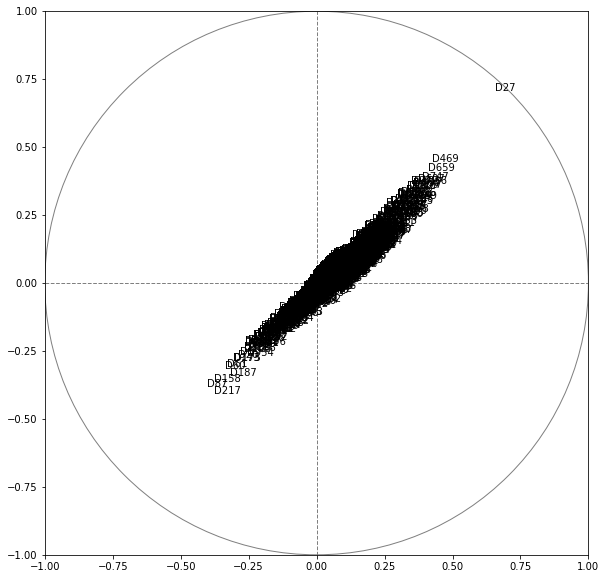

In [ ]:
#cercle des corrélations
fig, axes = plt.subplots(figsize=(10,10))
axes.set_xlim(-1.0,1.0)
axes.set_ylim(-1.0,1.0)
#position des variables
for i in range(dfCorr.shape[0]):
  plt.annotate(dfCorr.index[i],(correlations[i,0],correlations[i,1]))
#axes
plt.plot([0,0],[-1,+1],linestyle='--',c='gray',linewidth=1)
plt.plot([-1,+1],[0,0],linestyle='--',c='gray',linewidth=1)
#cosmétique
circle = plt.Circle((0,0),radius=1,fill=False,edgecolor='gray')
axes.add_artist(circle)
axes.set_aspect(1)
plt.show()

In [ ]:
#Restitution des données dans l’espace initial
XP = std.inverse_transform(ZP)
dp = pd.DataFrame(XP,columns=df_X_train.columns,index=df_X_train.index)
print(df_X_train)
print(ZP)
print(dp)

            D1        D2    D3   D4  ...  D1773  D1774  D1775  D1776
0     0.000000  0.497009  0.10  0.0  ...      0      0      0      0
1     0.366667  0.606291  0.05  0.0  ...      0      0      1      0
2     0.033300  0.480124  0.00  0.0  ...      0      0      0      0
3     0.000000  0.538825  0.00  0.5  ...      0      0      0      0
4     0.100000  0.517794  0.00  0.0  ...      0      0      0      0
...        ...       ...   ...  ...  ...    ...    ...    ...    ...
3746  0.033300  0.506409  0.10  0.0  ...      0      0      0      0
3747  0.133333  0.651023  0.15  0.0  ...      1      0      0      0
3748  0.200000  0.520564  0.00  0.0  ...      0      0      0      0
3749  0.100000  0.765646  0.00  0.0  ...      0      0      0      0
3750  0.133333  0.533952  0.00  0.0  ...      0      0      0      0

[3751 rows x 1776 columns]
[[ 0.35068324  0.575726   -0.04486781 ... -0.07723323 -0.04746826
   0.64482945]
 [ 0.42393956  0.70321226 -0.05856539 ... -0.10118291 -0.062259

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Input of the model
input_shape = (1776,) #1776 descriptors
inputs = keras.Input(shape=input_shape)
print(inputs.shape)
print(inputs.dtype)
#drop_out_1 = layers.Dropout(0.2)(inputs)
#Model layers
hidden1 = layers.Dense(64, activation="relu")(inputs)
hidden2 = layers.Dense(64, activation="relu")(hidden1)

#hidden3 = layers.Dense(64, activation="relu")(hidden2), 3755 1 hidden
outputs = layers.Dense(1, activation ="linear")(hidden2) #shape = 1 -> One value between 0 and 1 (regression)
model_after_ae = keras.Model(inputs=inputs, outputs=outputs,name="bioresponse_model")

#Compile model
#Binary Cross-Entropy specifies that the model should optimize the log loss
model_after_ae.compile(
    #loss=keras.losses.MeanSquaredError(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #Evaluate the model with the log loss 
    optimizer=keras.optimizers.SGD(learning_rate=0.01), #ou Adagrad avec haut LR
    #metrics=[soft_acc] #Compute accuracy for a regression model
    metrics=["accuracy"]
)

(None, 1776)
<dtype: 'float32'>


In [ ]:
histori_after_ae=model_after_ae.fit(dp,df_y_train, batch_size=75, epochs= 40, validation_split=0.2)

Epoch 1/40
40/40 [==============================] - 1s 10ms/step - loss: 0.6595 - accuracy: 0.6377 - val_loss: 0.6537 - val_accuracy: 0.7630
Epoch 2/40
40/40 [==============================] - 0s 4ms/step - loss: 0.6393 - accuracy: 0.8067 - val_loss: 0.6452 - val_accuracy: 0.7617
Epoch 3/40
40/40 [==============================] - 0s 3ms/step - loss: 0.6306 - accuracy: 0.7983 - val_loss: 0.6387 - val_accuracy: 0.7617
Epoch 4/40
40/40 [==============================] - 0s 4ms/step - loss: 0.6232 - accuracy: 0.8043 - val_loss: 0.6326 - val_accuracy: 0.7643
Epoch 5/40
40/40 [==============================] - 0s 5ms/step - loss: 0.6162 - accuracy: 0.8003 - val_loss: 0.6262 - val_accuracy: 0.7656
Epoch 6/40
40/40 [==============================] - 0s 4ms/step - loss: 0.6091 - accuracy: 0.8013 - val_loss: 0.6197 - val_accuracy: 0.7630
Epoch 7/40
40/40 [==============================] - 0s 4ms/step - loss: 0.6015 - accuracy: 0.8033 - val_loss: 0.6128 - val_accuracy: 0.7617
Epoch 8/40
40/40 [=

In [ ]:
#Test the model
loss, acc = model_after_ae.evaluate(df_X_test, df_y_test, verbose=1)
print(loss) #1.25 loss : résultats du modele FC entrainé à partir des données restituées par l'auto encodeur

79/79 [==============================] - 0s 3ms/step - loss: 1.1613 - accuracy: 0.0000e+00
1.1613045930862427


In [ ]:
#KNN https://realpython.com/knn-python/#using-scikit-learn-to-inspect-model-fit
#Regression based on k-nearest neighbors.
#The target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set.
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV #Exhaustive search over specified parameter values for an estimator.
parameters = {"n_neighbors": range(1, 10)}
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
gridsearch.fit(df_X_train, df_y_train)
print(gridsearch.best_params_)#best params = 7

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
data = pd.read_csv(train_path)
y = data['Activity']
data.drop(['Activity'], axis=1, inplace=True)
data_X_train, data_X_valid, data_y_train, data_y_valid = train_test_split(data, y, train_size=0.8, test_size=0.2) #split du train data pour pouvoir tester le knn 

#Moins bon résultats en standardisant les données 
#scaler = MinMaxScaler()
#scaler.fit(data_X_train)
#data_X_train = scaler.transform(data_X_train)
#data_X_valid = scaler.transform(data_X_valid)


In [ ]:
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
knn_model = KNeighborsRegressor(n_neighbors=7,weights='uniform', algorithm = 'auto')#-> meme resultats qqsoit les param du knn, log_loss = 1.6
#To get the data into the model, you can then fit the model on the training dataset
knn_model.fit(data_X_train, data_y_train)

train_preds = knn_model.predict(data_X_train)
train_loss =  log_loss(data_y_train, train_preds)
train_mse = mean_squared_error(data_y_train, train_preds)
print(train_loss)
print(train_mse)


0.400812529321206
0.13440816326530614


In [ ]:
test_preds = knn_model.predict(data_X_valid)
test_loss =  log_loss(data_y_valid, test_preds) #environ 1.6
test_mse = mean_squared_error(data_y_valid, test_preds)#environ 0.10/0.20
print(test_loss) #1.84 avec 5 voisins, 1.11 avec 7 voisins
print(test_mse)

1.4343129244654587
0.1734014511263893


In [ ]:
#from sklearn.metrics import classification_report, confusion_matrix
#print(confusion_matrix(data_y_train, train_preds))
#print(classification_report(data_y_train, train_preds))

In [ ]:
#SVM -> SVR pour régression
#https://scikit-learn.org/stable/modules/svm.html#regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
regr = make_pipeline(MinMaxScaler(), SVR(C=1.0, epsilon=0.2,gamma='scale', kernel='rbf'))
regr.fit(data_X_train, data_y_train)

Pipeline(memory=None,
         steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('svr',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2,
                     gamma='scale', kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [ ]:
svm_preds = regr.predict(data_X_train)
svm_loss =  log_loss(data_y_train, svm_preds)
print (svm_preds)
print(svm_loss)

[0.55860096 0.19987105 0.79983453 ... 1.08659825 0.80012571 0.80028814]
0.30226784280218355


In [ ]:
svm_test = regr.predict(data_X_valid)
svm_test_loss =  log_loss(data_y_valid, svm_test)
print(svm_test_loss) #Loss = 0.51
#svm_test_2 = regr.predict(df_X_test)
#svm_test_loss =  log_loss(df_y_test , svm_test_2)
#print(svm_test_loss) 

0.5225338788680866


In [ ]:
from sklearn.model_selection import GridSearchCV #Exhaustive search over specified parameter values for an estimator.
#parameters = [{'kernel': ['poly', 'rbf', 'sigmoid'], 'gamma': ['scale', 'auto'],
                     #'C': [1, 10]}, {'kernel': ['linear'], 'C': [1, 10]}]
parameters = {'kernel': ['poly', 'rbf', 'sigmoid'], 'gamma': ['scale', 'auto'],'C': [1, 10]}
gridsearch_svr = GridSearchCV(SVR(), parameters)
gridsearch_svr.fit(data_X_train, data_y_train)

print(gridsearch_svr.best_params_) #SVR(C=1.0, epsilon=0.2,gamma='scale', kernel='rbf'))

In [ ]:
#EDA
#df_X_train
df_X_train.info()
df_X_train.describe().T



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1776 entries, D1 to D1776
dtypes: float64(942), int64(834)
memory usage: 50.8 MB


count      mean       std  ...       50%       75%       max
D1     3751.0  0.076948  0.079989  ...  0.066700  0.100000  1.000000
D2     3751.0  0.592436  0.105860  ...  0.585989  0.668395  0.964381
D3     3751.0  0.068142  0.078414  ...  0.050000  0.100000  0.950000
D4     3751.0  0.038990  0.115885  ...  0.000000  0.000000  1.000000
D5     3751.0  0.212112  0.102592  ...  0.190926  0.261726  1.000000
...       ...       ...       ...  ...       ...       ...       ...
D1772  3751.0  0.016796  0.128522  ...  0.000000  0.000000  1.000000
D1773  3751.0  0.012263  0.110074  ...  0.000000  0.000000  1.000000
D1774  3751.0  0.011730  0.107683  ...  0.000000  0.000000  1.000000
D1775  3751.0  0.020261  0.140911  ...  0.000000  0.000000  1.000000
D1776  3751.0  0.011197  0.105236  ...  0.000000  0.000000  1.000000

[1776 rows x 8 columns]

             0
D27   0.472340
D87  -0.223081
D146  0.213311
D182  0.228664
D209  0.210154
D217 -0.233387
D469  0.268601
D596  0.204092
D607  0.210270
D659  0.226049
D660  0.204864
D747  0.226468


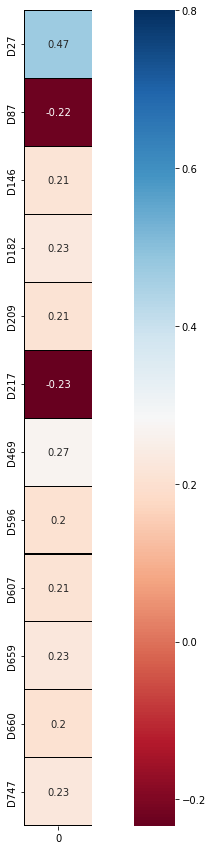

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
#corr =X_train[X_train.columns[1:]].corr(method='spearman')X_train[X_train.columns[0]]
corr = df_X_train.apply(lambda x: x.corr(df_y_train))
corr = pd.DataFrame(corr)
corr = corr.loc[abs(corr[0]) > 0.2]
print(corr)
plt.figure(figsize=(15,15))
sn.heatmap(corr, vmax = .8, linewidths = 0.01,square = True, annot = True, cmap = 'RdBu', linecolor = 'black')
#sn.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot= True)

In [ ]:
#https://plotly.com/python/pca-visualization/
#Visualize original dimension 
import plotly.express as px
data = pd.read_csv(train_path)
fig = px.scatter_matrix(
    data,
    dimensions=data.iloc[:,1:10],
    color="Activity"
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
components = pca.fit_transform(data.iloc[:,1:10])
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(4),
    color=data["Activity"]
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [76]:
#https://medium.com/dataseries/multidimensional-scaling-for-dissimilarity-visualization-9fb061396cf3
#MDS : visualisation
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
#dis_matrix = pairwise_distances(X_train, metric = 'jaccard')
#print(dis_matrix.shape)
embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(X_scaled)
print(X_transformed)

[[ -2.2269801    0.05728027]
 [  5.73146313  17.06533943]
 [ -4.81196117   1.82477957]
 ...
 [ -6.15580789 -10.03063073]
 [ -6.64880578  -4.41156092]
 [ -8.31642534   0.3782657 ]]


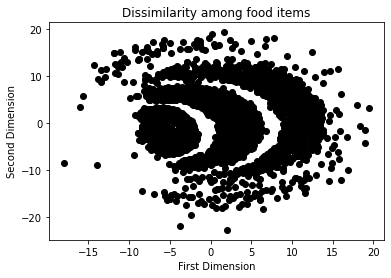

In [ ]:
X_transformed.shape

plt.figure()
plt.scatter(X_transformed[:,0],X_transformed[:,1],
    facecolors = 'black', edgecolors = 'black')  # points in white (invisible)
labels = df_X_train.columns
#for label, x, y in zip(labels, X_transformed[:,0], X_transformed[:,1]):
    #plt.annotate(label, (x,y), xycoords = 'data')
plt.xlabel('First Dimension')
plt.ylabel('Second Dimension')
plt.title('Dissimilarity among food items')    
plt.show()

ValueError: ignored

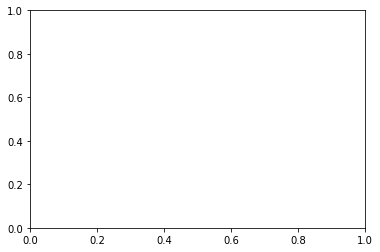

In [77]:
#https://stackabuse.com/guide-to-multidimensional-scaling-in-python-with-scikit-learn/
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
dist_euclid = euclidean_distances(df_X_train)
stress = []
# Max value for n_components
max_range = 10
for dim in range(2, max_range):
    # Set up the MDS object
    mds = MDS(n_components=dim, dissimilarity='precomputed', random_state=0)
    # Apply MDS
    pts = mds.fit_transform(dist_euclid)
    # Retrieve the stress value
    stress.append(mds.stress_)
# Plot stress vs. n_components    
plt.plot(range(2, max_range), stress)
plt.xticks(range(2, max_range, 2))
plt.xlabel('n_components')
plt.ylabel('stress')
plt.show()

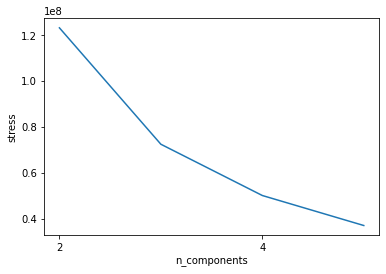

In [78]:
# Plot stress vs. n_components    
plt.plot(range(2, max_range), stress)
plt.xticks(range(2, max_range, 2))
plt.xlabel('n_components')
plt.ylabel('stress')
plt.show()

In [ ]:
#Random Forest , K-trees
from sklearn.ensemble import RandomForestRegressor
rforest = RandomForestRegressor(n_estimators=400, max_depth=20, random_state=0) #{'max_depth': 20, 'n_estimators': 400}
rforest.fit(data_X_train, data_y_train)
#print_accuracy(rforest.predict)

#https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Diabetes%20regression.html

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
from sklearn.metrics import log_loss, mean_squared_error
rfr_train = rforest.predict(data_X_train)
rfr_test = rforest.predict(data_X_valid)

rfr_train_loss = log_loss(data_y_train, rfr_train)
rfr_test_loss = log_loss(data_y_valid, rfr_test)
print(rfr_train_loss)
print(rfr_test_loss)

0.14158395419356684
0.4680845469351382


In [ ]:
cor= df_X_train.corr(method='pearson')
print(cor)

             D1        D2        D3  ...     D1774     D1775     D1776
D1     1.000000  0.262487  0.328325  ...  0.164529  0.237026  0.186957
D2     0.262487  1.000000  0.439590  ...  0.043174  0.027019  0.073585
D3     0.328325  0.439590  1.000000  ...  0.142170  0.008959  0.198354
D4     0.260002  0.352263  0.188451  ...  0.027448  0.008766  0.068058
D5    -0.074244  0.227328 -0.123794  ... -0.105049 -0.137316 -0.102322
...         ...       ...       ...  ...       ...       ...       ...
D1772  0.234814  0.017283  0.021355  ...  0.101371  0.422945  0.262122
D1773  0.096729  0.023722  0.053000  ...  0.325325  0.293441  0.333455
D1774  0.164529  0.043174  0.142170  ...  1.000000  0.300667  0.411980
D1775  0.237026  0.027019  0.008959  ...  0.300667  1.000000  0.182508
D1776  0.186957  0.073585  0.198354  ...  0.411980  0.182508  1.000000

[1776 rows x 1776 columns]


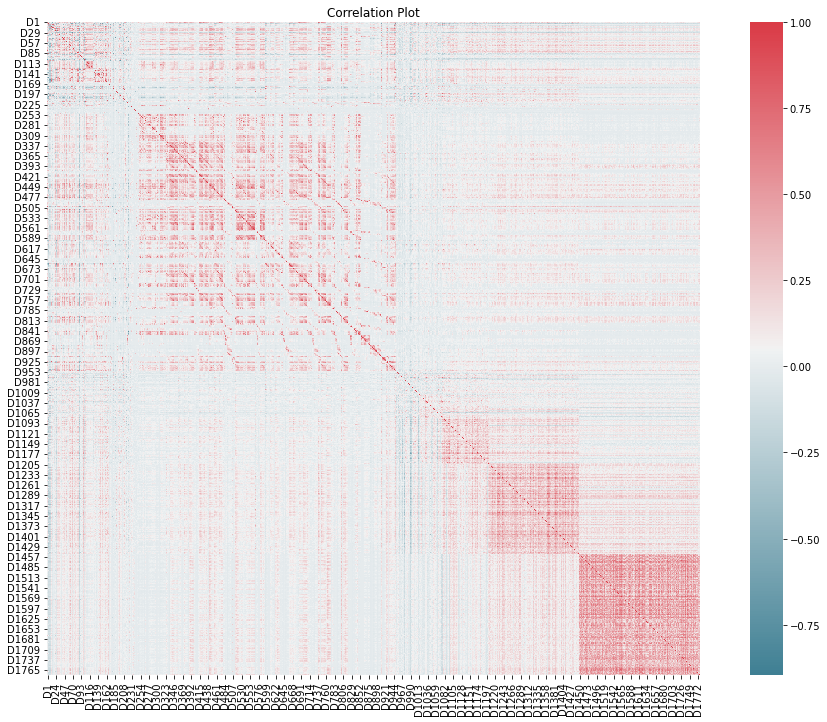

In [ ]:
#https://www.kaggle.com/sociopath00/random-forest-using-gridsearchcv
import seaborn as sn
import matplotlib.pyplot as plt
fig, ax =plt.subplots(figsize=(18, 12))
plt.title("Correlation Plot")
sn.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sn.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

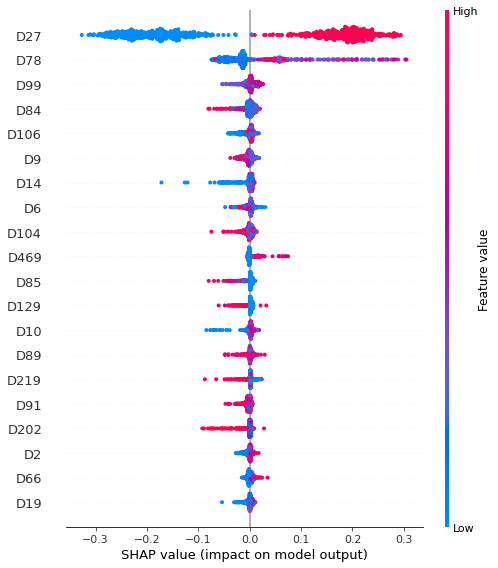

In [ ]:
import shap
explainer = shap.TreeExplainer(rforest)
shap_values = explainer.shap_values(data_X_valid)
shap.summary_plot(shap_values, data_X_valid)

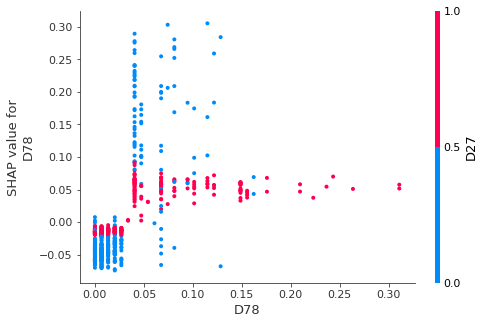

In [ ]:
shap.dependence_plot("D78", shap_values, data_X_valid)

In [ ]:
from sklearn.neural_network import MLPRegressor
nn = MLPRegressor(solver='sgd', alpha=1e-1, hidden_layer_sizes=(5, 2), random_state=0, max_iter=500)
nn.fit(data_X_train, data_y_train)
X_train_summary = shap.kmeans(data_X_train, 3)
nn_train = nn.predict(data_X_train)
nn_test = nn.predict(data_X_valid)

nn_train_loss = log_loss(data_y_train, nn_train)
nn_test_loss = log_loss(data_y_valid, nn_test)
print(nn_train_loss)
print(nn_test_loss)

0.43959330105981476
0.6435128658184228


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


  0%|          | 0/751 [00:00<?, ?it/s]

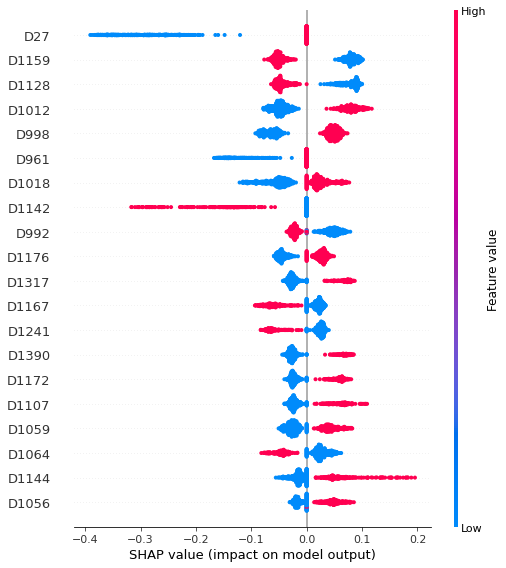

In [ ]:
# explain all the predictions in the test set
explainer = shap.KernelExplainer(nn.predict, X_train_summary)
shap_values = explainer.shap_values(data_X_valid)
shap.summary_plot(shap_values, data_X_valid)

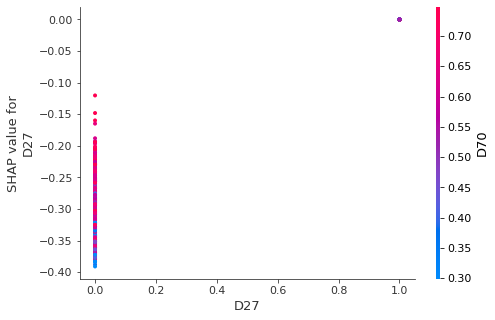

In [ ]:
shap.dependence_plot("D27", shap_values, data_X_valid)

In [ ]:
from sklearn.model_selection import GridSearchCV #Exhaustive search over specified parameter values for an estimator
from sklearn.ensemble import RandomForestRegressor
#parameters = {'n_estimators' : [100,200,400], 'max_depth' : [5,10,20] }
param_grid = { 
    'n_estimators': [200,300, 400, 500,600],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [5,20,40],
    #'criterion' :['gini', 'entropy']
}
gridsearch = GridSearchCV(RandomForestRegressor(), param_grid)
gridsearch.fit(data_X_train, data_y_train)
print(gridsearch.best_params_)#best params 